## Import libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import (TimeSeriesSplit, RandomizedSearchCV)

import xgboost as xgb

## Load and inspect data

In [5]:
# 2.1. Read the pre-computed, influence-weighted sentiment + price data
train_df = pd.read_excel("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_.xlsx",  parse_dates=["trading_day","Date"])
val_df   = pd.read_excel("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data.xlsx", parse_dates=["trading_day","Date"])
test_df  = pd.read_excel("/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data.xlsx",       parse_dates=["trading_day","Date"])

## Drop unused columns

In [3]:
drop_cols = ["Date","trading_day","Close","High","Low","Open","Volume","VIX"]
# plus any text fields e.g. X_Post, etc.
train_df.drop(columns=drop_cols, inplace=True)
val_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

## Define X & y

In [6]:
# assume train_df, val_df, test_df already loaded, and sentiment cols there

for df in (train_df, val_df, test_df):
    # 1) lagged returns: t-1, t-2, t-3
    for lag in (1,2,3):
        df[f"ret_lag{lag}"] = df["return_t"].shift(lag)

    # 2) high-low & open-close spreads
    df["HL_spread"] = df["High"] - df["Low"]
    df["OC_spread"] = df["Open"] - df["Close"]

    # 3) log volume
    df["log_vol"] = np.log1p(df["Volume"])

    # 4) VIX change
    df["VIX_chg"] = df["VIX"].pct_change()

    # 5) 5-day rolling return & volatility
    df["ret_5d_avg"]  = df["return_t"].rolling(5).mean()
    df["ret_5d_vol"]  = df["return_t"].rolling(5).std()

# now drop any rows with NaNs from these shifts/rolls
for df in (train_df, val_df, test_df):
    df.dropna(subset=[
        # keep all the new features + your old target
        *["ret_lag1","ret_lag2","ret_lag3","HL_spread","OC_spread",
          "log_vol","VIX_chg","ret_5d_avg","ret_5d_vol",
          "SWIS_Equal","SWIS_Ratio","SWIS_Impurity","SWIS_perm",
          "SWIS_SHAP","Sentiment_score","return_t","return_t+1"]
    ], inplace=True)

# redefine the feature list
FEATURES = [
    # sentiment:
    "SWIS_Equal","SWIS_Ratio","SWIS_Impurity",
    "SWIS_perm","SWIS_SHAP","Sentiment_score",
    # price‐history:
    "return_t","ret_lag1","ret_lag2","ret_lag3",
    "HL_spread","OC_spread","log_vol","VIX_chg",
    "ret_5d_avg","ret_5d_vol",
]
TARGET = "return_t+1"

# and rebuild X/y as before:
X_train = train_df[FEATURES];  y_train = train_df[TARGET]
X_val   = val_df[FEATURES];    y_val   = val_df[TARGET]
X_test  = test_df[FEATURES];   y_test  = test_df[TARGET]


## Baseline

In [7]:
y_pred_baseline = np.roll(y_val, 1)  # naive: tomorrow = today
print("Baseline R²:", r2_score(y_val[1:], y_pred_baseline[1:]))

Baseline R²: -1.0640568990027695


## XGBoost model and hyperparameter tuning

In [8]:
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",     # fast approximate tree
    random_state=42
)

# 7.1. Parameter grid for RandomizedSearch
param_dist = {
    "n_estimators": [100, 300, 500, 800],
    "max_depth":    [3, 5, 7, 10],
    "learning_rate":[0.01, 0.05, 0.1, 0.2],
    "subsample":    [0.6, 0.8, 1.0],
    "colsample_bytree":[0.6, 0.8, 1.0],
    "reg_alpha":    [0, 0.1, 1, 5],
    "reg_lambda":   [1, 5, 10],
    'grow_policy': ['depthwise', 'lossguide'] # Add grow_policy options
}

# 7.2. Time-series split so we don’t leak future info
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator    = xgb_model,
    param_distributions=param_dist,
    n_iter       = 50,
    scoring      = "neg_mean_squared_error",
    cv           = tscv,
    verbose      = 2,
    random_state = 42,
    n_jobs       = -1
)

# 7.3. Fit on training only (we’ll validate on validation set)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'colsample_bytree': 1.0}


## Check for missing values

In [9]:
# show how many missings in each column of X_test
print(X_test.isna().sum().sort_values(ascending=False).head(10))

# and check y_test itself
print("y_test nulls:", y_test.isna().sum())


SWIS_Equal         0
SWIS_Ratio         0
SWIS_Impurity      0
SWIS_perm          0
SWIS_SHAP          0
Sentiment_score    0
return_t           0
ret_lag1           0
ret_lag2           0
ret_lag3           0
dtype: int64
y_test nulls: 0


## Final training & evaluation

In [10]:
best = search.best_estimator_

# 8.1. Retrain on (train + val) if you like, or just on train
best.fit(X_train, y_train)

# 8.2. Predict
y_val_pred  = best.predict(X_val)
y_test_pred = best.predict(X_test)

# 8.3. Metrics function
def report(y_true, y_pred, name="set"):
    mse   = mean_squared_error(y_true, y_pred)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(y_true, y_pred)
    r2    = r2_score(y_true, y_pred)
    print(f"*** {name} ***")
    print(f" R²   = {r2:.4f}")
    print(f" MSE  = {mse:.6f}")
    print(f" RMSE = {rmse:.6f}")
    print(f" MAE  = {mae:.6f}\n")

report(y_val,  y_val_pred,  "Validation")
report(y_test, y_test_pred, "Test")

# 8.4. Out-of-sample R² relative to in-sample mean
y_train_mean = y_train.mean()
rss = ((y_test - y_test_pred)**2).sum()
tss = ((y_test - y_train_mean)**2).sum()
oos_r2 = 1 - rss/tss
print("Out-of-sample R² (baseline = train mean):", oos_r2)


*** Validation ***
 R²   = -0.0531
 MSE  = 0.000049
 RMSE = 0.007035
 MAE  = 0.005396

*** Test ***
 R²   = -0.0411
 MSE  = 0.000077
 RMSE = 0.008748
 MAE  = 0.006347

Out-of-sample R² (baseline = train mean): -0.03145057209713342


##Feature importance & diagnostics

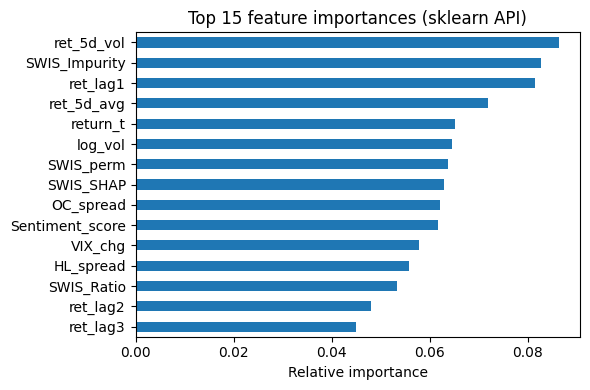

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the array of importances & wrap in a Series
imp_ser = pd.Series(
    best.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

# 2. Take the top 15 and bar‐plot
imp_ser.head(15).sort_values().plot(
    kind="barh",
    figsize=(6,4),
    title="Top 15 feature importances (sklearn API)"
)
plt.xlabel("Relative importance")
plt.tight_layout()
plt.show()
